In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sy
np.set_printoptions(suppress=True, precision=4)
from scipy.linalg import expm, logm
import scipy
from numba import jit, njit

from plot_helpers import plotCoordinateFrame, set_axes_equal

In [2]:
# @njit
def SO3_from_vec(w):
    wx = skew(w)
    theta = np.linalg.norm(w)
    if np.abs(theta) < 0.0001:
        R = np.eye(3) + wx + wx@wx/2 + wx@wx@wx/6
    
    else:
        A = np.sin(theta) / theta
        B = (1 - np.cos(theta)) / theta**2
        R = np.eye(3) + A*wx + B*wx@wx
    
    return R

In [3]:
# Helpers
@njit
def skew(u):
    return np.array([[   0, -u[2],  u[1]],
                    [ u[2],     0, -u[0]],
                    [-u[1],  u[0],     0]])

@njit
def rodrigues(r):
    '''
    Q3.2: Rodrigues formula.
        Input:  r, a 3x1 vector
        Output: R, a 3x3 rotation matrix
    '''
    theta = np.sqrt(r[0]**2 + r[1]**2 + r[2]**2)
    u = r/ theta
    
    R = np.eye(3)*np.cos(theta) + (1- np.cos(theta))*np.outer(u,u) + skew(u)*np.sin(theta)
    
    return R

@njit
def invRodrigues(R):
    '''
    Q5.2: Inverse Rodrigues formula.
        Input:  R, a 3x3 rotation matrix
        Output: r, a 3x1 vector
    '''
    # ----- TODO -----
    A = (R - R.T)/2
    rho = np.array([A[2,1], A[0,2], A[1,0]])
    
    s = np.linalg.norm(rho)
    c = (np.sum(np.diag(R)) -1)/2
    
    u = rho/s
    theta = np.arctan2(s, c)
    r = u*theta
    
    return r

@njit
def K_from_vec(x):
    K = np.zeros((3,4))
    K[0,0] = x[0]
    K[1,1] = x[1]
    K[2,2] = 1
    K[0:2,2] = x[2:4]
    return K

@njit
def vec_from_K(K):
    return np.array([K[0,0], K[1,1], K[0,2], K[1,2]])

@njit
def SE3_from_vec(xi):
    T = np.eye(4)
    T[:3,:3] = rodrigues(xi[:3])
    T[:3,3] = xi[3:]
    return T
 
@njit
def vec_from_SE3(T):
    return np.concatenate(( invRodrigues(T[:3,:3]), T[:3,3] ))

@njit
def to_linear(T, K, P):
    return np.concatenate(( vec_from_SE3(T), vec_from_K(K), P.flatten() ))
    
@njit
def from_linear(x):
    T = SE3_from_vec(x[:6])
    K = K_from_vec(x[6:10])
    P = x[10:].reshape((N,3))
    return T, K, P

@njit
def to_homogen(p):
    return np.hstack(( p, np.ones((p.shape[0], 1)) ))

@njit
def from_homogen(p):
    p /= p[:,-1:]
    return p[:,:-1]

@njit
def h(P, K, T):
    p_homo = K@T@to_homogen(P).T
    return from_homogen(p_homo.T)

### Create fake ground truth data

In [4]:
K_gt = np.array([[1520 ,    0.  ,  300, 0],
               [   0.  , 1500 ,  250, 0],
               [   0.  ,    0.  ,    1., 0]])

# Make P the 2 sides of a box
x = np.linspace(0,2,10)
y = np.linspace(-1,1,10)
X, Y = np.meshgrid(x,y)
X = X.flatten()
Y = Y.flatten()
Z = -X + 5
P1 = np.column_stack((X,Y,Z))

x = np.linspace(-2,0,10)
y = np.linspace(-1,1,10)
X, Y = np.meshgrid(x,y)
X = X.flatten()
Y = Y.flatten()
Z = X + 5
P2 = np.column_stack((X,Y,Z))

P_gt = np.vstack((P1,P2))
N = P_gt.shape[0]

# Ground truth poses
T1_gt = np.eye(4)
T2_gt = SE3_from_vec(np.array([.2, -10*np.pi/180, .1, 0.7, 0.3, 0.1]))

### Apply noise to data

In [5]:
# Initial guesses
P = P_gt + np.random.normal(scale=0.3, size=P_gt.shape)
T2 = T2_gt@SE3_from_vec(np.array([*np.random.normal(scale=0.2,size=3), *np.random.normal(scale=0.3,size=3)]))
K = K_from_vec( vec_from_K(K_gt) + np.random.normal(scale=30) )

# Generate data
p1 = h(P_gt, K_gt, T1_gt) + np.random.normal(scale=1)
p2 = h(P_gt, K_gt, T2_gt) + np.random.normal(scale=1)

### Setup problem!

In [6]:
def residuals(x):
    # Extract info
    T2, K, P = from_linear(x)
       
    # Compute expected measurements
    p1_prime = h(P, K, np.eye(4))
    p2_prime = h(P, K, T2)
    
    return np.concatenate(( (p1 - p1_prime).flatten(), (p2 - p2_prime).flatten() ))

def residuals_normed(x):
    return np.linalg.norm(residuals(x))

x = to_linear(T2_gt, K_gt, P_gt)
print(residuals_normed(to_linear(T2, K, P)))

9265.017583049927


In [7]:
# %time result = scipy.optimize.minimize(residuals_normed, to_linear(T2, K, P), method="Powell")
%time result = scipy.optimize.least_squares(residuals, to_linear(T2, K, P), method='lm')
print(result.cost)

CPU times: user 3.26 s, sys: 0 ns, total: 3.26 s
Wall time: 3.25 s
2.9301920623030857e-24


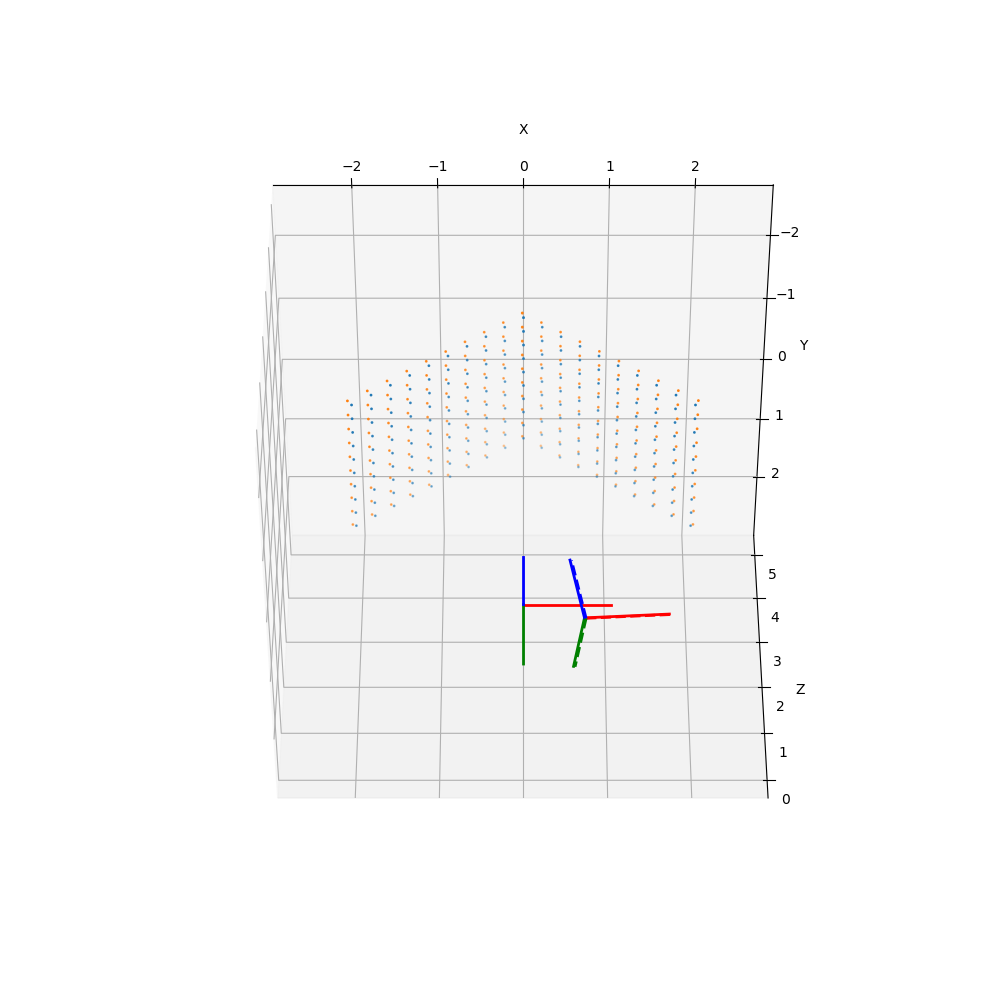

In [9]:
# %matplotlib widget
x = to_linear(T2, K, P)
x = result.x.copy()
T2_result, K_result, P_result = from_linear(x)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(P_gt[:,0], P_gt[:,1], P_gt[:,2], s=1)
ax.scatter(P_result[:,0], P_result[:,1], P_result[:,2], s=1)
plotCoordinateFrame(T1_gt, ax=ax)
plotCoordinateFrame(T2_gt, ax=ax)
plotCoordinateFrame(T2_result, ax=ax, k="--")
set_axes_equal(ax)
ax.set_zlabel("Z")
ax.set_ylabel("Y")
ax.set_xlabel("X")
ax.view_init(-45, -90)
plt.show()